In [1]:
#Installing detectron2

!pip install pyyaml==5.1
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=d49a92ee1fb5b0f40910a37afc67ece92b1874179bfcb4782773c4573e84ad88
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

In [2]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Restart runtime before running all the following cells

# import some common libraries

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import os
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import time
import datetime
import torch
import logging
import tensorflow as tf

# import some common detectron2 utilities

import detectron2
import detectron2.utils.comm as comm
!python -m pip install -e detectron2.utils.logger
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode


ERROR: detectron2.utils.logger is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [3]:
#Some useful definitions:

#To evaluate validation loss while training

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

#Default trainer

class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    return COCOEvaluator(dataset_name, cfg, True, output_folder)

  def build_hooks(self):
    hooks = super().build_hooks()
    hooks.insert(-1,LossEvalHook(
        self.cfg.TEST.EVAL_PERIOD,
        self.model,
        build_detection_test_loader(
            self.cfg,
            self.cfg.DATASETS.TEST[0],
            DatasetMapper(self.cfg,True)
        )
    ))
    return hooks

#Loading json file

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines



In [4]:
os.chdir('/content/drive/MyDrive/Mart/iii')

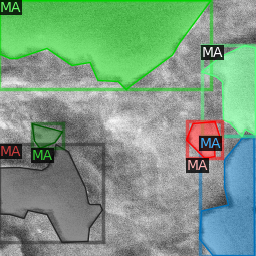

In [5]:
#Registering train dataset

tr_name="train"
try :
  register_coco_instances(tr_name, {}, "/content/drive/MyDrive/Mart/iii/label/joinann.json", "/content/drive/MyDrive/Mart/iii/im_join")
except Exception as e :
  print(repr(e))

train_metadata = MetadataCatalog.get(tr_name)
dataset_dicts = DatasetCatalog.get(tr_name)

#Visualisation

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])



In [6]:
#Registering validation dataset

val_name="val"
try :
  register_coco_instances (val_name, {}, "/content/drive/MyDrive/Mart/iii/label/val.json", "/content/drive/MyDrive/Mart/iii/im_val")
except Exception as e:
  print(repr(e))

val_metadata = MetadataCatalog.get(val_name).set(thing_classes=["MA"])
dataset_dicts_val = DatasetCatalog.get(val_name)

In [7]:
torch.cuda.empty_cache()

In [8]:
#Training using cocotrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))#the model
cfg.DATASETS.TRAIN = (tr_name,)
cfg.DATASETS.TEST = (val_name,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.01 # learning rate
cfg.SOLVER.GAMMA = 0.5 #Learning rate change per epoch
cfg.SOLVER.MAX_ITER = 750  # no of iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size".(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (MA). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.TEST.EVAL_PERIOD = 20
cfg.OUTPUT_DIR="/content/Out"
#cfg.MODEL.DEVICE="cpu"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#Extracting trained model weigths

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # set a custom testing threshold
predictor = DefaultPredictor(cfg)



[06/20 15:06:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:02, 205MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/20 15:06:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/20 15:06:46 d2.data.datasets.coco]: Loaded 48 images in COCO format from /content/drive/MyDrive/Mart/iii/label/val.json
[06/20 15:06:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/20 15:06:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/20 15:06:46 d2.data.common]: Serializing 48 elements to byte tensors and concatenating them all ...
[06/20 15:06:46 d2.data.common]: Serialized dataset takes 0.07 MiB
WARNING [06/20 15:06:46 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/20 15:06:46 d2.evaluation.evaluator]: Start inference on 48 batches
[06/20 15:06:50 d2.evaluation.evaluator]: Inference done 11/48. Dataloading: 0.0971 s/iter. Inference: 0.1857 s/iter. Eval: 0.0168 s/iter. Total: 0.2996 s/iter. ETA=0

Raw				Label				Detection


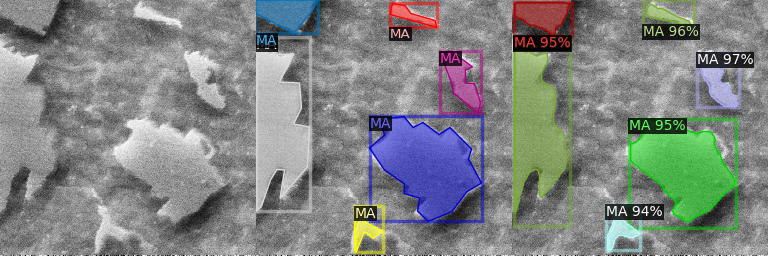

In [9]:
#Visualising our model in the validation dataset

for d in random.sample(dataset_dicts_val, 1):

    im = cv2.imread(d["file_name"])
    '''print("Raw")
    cv2_imshow(im)'''

    visualizer1 = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=1,)
    vis1 = visualizer1.draw_dataset_dict(d)
    '''print("Label")
    cv2_imshow(vis1.get_image()[:, :, ::-1])'''

    outputs = predictor(im)
    visualiser2 = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=1,)
    vis2 = visualiser2.draw_instance_predictions(outputs["instances"].to("cpu"))
    '''print("Detection")
    cv2_imshow(vis2.get_image()[:, :, ::-1])'''

    print("Raw\t\t\t\tLabel\t\t\t\tDetection")
    cv2_imshow(np.hstack([im,vis1.get_image()[:,:,::-1],vis2.get_image()[:,:,::-1]]))



In [10]:
#Evaluating it in the validation set

evaluator = COCOEvaluator(val_name, output_dir="/content/Out")
val_loader = build_detection_test_loader(cfg, val_name)
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[06/20 15:33:08 d2.data.datasets.coco]: Loaded 48 images in COCO format from /content/drive/MyDrive/Mart/iii/label/val.json
[06/20 15:33:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/20 15:33:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/20 15:33:08 d2.data.common]: Serializing 48 elements to byte tensors and concatenating them all ...
[06/20 15:33:08 d2.data.common]: Serialized dataset takes 0.07 MiB
[06/20 15:33:08 d2.evaluation.evaluator]: Start inference on 48 batches
[06/20 15:33:10 d2.evaluation.evaluator]: Inference done 11/48. Dataloading: 0.0012 s/iter. Inference: 0.1823 s/iter. Eval: 0.0008 s/iter. Total: 0.1844 s/iter. ETA=0:00:06
[06/20 15:33:15 d2.evaluation.evaluator]: Inference done 38/48. Dataloading: 0.0029 s/iter. Inference: 0.1829 s/iter. Eval: 0.0012 s/iter. Total: 0.1872 s/iter. ET

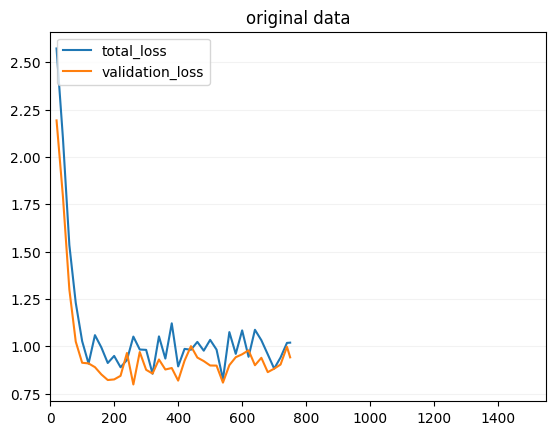

In [11]:
#Plotting metrics

experiment_metrics = load_json_arr('/content/Out/metrics.json')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x],
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.title('original data')
plt.xlim(0,1550)
plt.grid(axis='y', color='0.95')
plt.show()